# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico III : Introducción al aprendizaje automático

### Librerías

In [1]:
%%capture
!pip3 install spotipy
!pip3 install pandas
!pip3 install spacy
!pip3 install pymusixmatch
!pip3 install nltk
!pip3 install seaborn
!pip3 install requests
!pip3 install nltk
!pip3 install tqdm
!pip3 install plotly
!pip3 install sklearn
!pip3 install sentiment_analysis_spanish

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

Processing /home/kunan/.cache/pip/wheels/cd/22/66/fcfe16c783269151e68dfa0a25411b21a2d5d2106cda7dac1e/pymusixmatch-0.3-py3-none-any.whl
  Using cached stanza-1.1.1-py3-none-any.whl (227 kB)


### Dependencias y acceso a APIs

In [1]:
import pandas as pd
import numpy as np
import spotipy
import spacy
from spotipy.oauth2 import SpotifyClientCredentials
from musixmatch import Musixmatch
import seaborn as sns
import tqdm
import plotly.express as px
import plotly.graph_objects as go
import requests
from collections import Counter
from nltk import ngrams, bigrams
import nltk
import itertools
import matplotlib.pyplot as plt
import json
import spacy
from sentiment_analysis_spanish import sentiment_analysis
from  statistics import median,mean


client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

# es = es_core_web_sm
#python -m spacy link es_core_news_sm es
nlp = spacy.load("es")

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
musixmatch = Musixmatch('1aa5272f4402bf2f082ad2f3958c2c62') # se puede reemplazar por otra API si da mejores resultados

sentiment = sentiment_analysis.SentimentAnalysisSpanish()


In [2]:
sns.set_context(context='paper')

### 1) Recopilar los datos obtenidos en los prácticos anteriores

Para esta parte consideraremos [la playlist colaborativa de la mentoría](https://open.spotify.com/playlist/2IuD0qZb14cji5y52crdsO?si=nfHRPDquQRyotEcXc4tG7Q), de esta obtendremos:
- Las features del audio de las canciones
- Las features textuales de sus letras

Además es necesario aplicar el mismo preprocesamiento que aplicamos en los prácticos anteriores para ambos tipos de features (el preprocesamiento del p1 a las features de audio y el de p2 al de features textuales) y obtener el género de cada canción, que en caso de ser más de uno para una canción el equipo deberá discutir una estrategia para estos casos y comentarla en el informe.

Luego, se separará al dataset resultante en **X** e **y**, donde:
- X es el conjunto de features
- y es la etiqueta, en este caso el género de la canción, que deberá ser codificado en valores del tipo **int**

Por último, se dividirá a estos dos conjuntos en los splits **train** y **test**

**Recomendaciones:**
- Obtener las features por separado y hacer un join de los datasets.
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)
- Si usan features categóricas, ENCODEARLAS!

# Dataset

## Music Features

In [3]:
#Aux funcs
def genres_by_artist_id(id): #id: str
    artist = sp.artist(id)
    genres = artist['genres']
    return genres    #genres: List[str]

def songs_from_album_id(album_id):
    songs = []
    album = sp.album(album_id)
    artist = album['artists'][0]['name']
    for item in album['tracks']['items']:
        track = {}
        track["song_name"] = item['name']
        track["song_id"] = item['id']
        track["album_name"] = album['name']
        track["album_id"] = album["id"]
        audio_features = sp.audio_features(track["song_id"])
        track["audio_features"] = audio_features[0]
        track["artist"] = artist
        songs.append(track)
    return songs    #songs:List[dict]

def get_genres(artists_id):
    res = [genres_by_artist_id(x) for x in artists_id if genres_by_artist_id(x)!= []]
    if res != []:
        return res[0]
    return res

def add_track(track_id, songs): #track_id:str, songs:List[dict]
    track = sp.track(track_id)
    audio_features = sp.audio_features(track_id)
    row = {}
    row["song_name"] = track['name']
    row["song_id"] = track['id']
    row["artists"] = [x["name"] for x in track["artists"]]
    row["artists_id"] = [x["id"] for x in track["artists"]]
    row["album_name"] = track['album']['name']
    row["album_id"] = track['album']['id']
    row["audio_features"] = audio_features[0]
    row["genres"] = get_genres(row["artists_id"])
    songs.append(row)
    return songs


In [4]:

def songs_of_description(statistic):
    row = audio_features_description.loc[statistic]
    keys = row.keys()
    tracks_of_row = []
    for key in keys:
        track = track_by_feature(key,row[key]).to_dict()['song_name']
        track = list(track.values())[0]
        tracks_of_row.append({key: track})
    return tracks_of_row
#example use
#songs_of_description("min")

#songs_of_description("max")

In [224]:
#songs_of_description("min")

## Lyrics

In [5]:
songs_base = pd.read_csv("./final_big.csv",sep="#")
#let's get back our genres
songs_base["genres"]=songs_base["genres"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))


In [6]:
songs_base.head(5)

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key'...","[art pop, dance pop, deconstructed club, el...",0.0013
1,Anoche,1cwTMSQeMaA9fVKEF1iWeD,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.23, 'energy': 0.434, 'key':...","[art pop, dance pop, deconstructed club, el...",0.9970
2,Sin Rumbo,0aL27vskbMpwsMGUkHm3Zf,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.289, 'energy': 0.28, 'key':...","[art pop, dance pop, deconstructed club, el...",0.0000
3,La Gata Bajo la Lluvia,2kfSFdq2h0xLXq01em1zc7,['Rocío Dúrcal'],['2uyweLa0mvPZH6eRzDddeB'],Sus 16 Grandes Exitos,1QXxmsxolhkqiFtI1mpX4i,"{'danceability': 0.499, 'energy': 0.648, 'key'...","[bolero, cancion melodica, grupera, latin, ...",0.0057
4,Querida,5ySxlyvySBhIEvoO2xx7uT,['Juan Gabriel'],['2MRBDr0crHWE5JwPceFncq'],Recuerdos II,1xrQ48Vvnvm3SmAbnIukGt,"{'danceability': 0.528, 'energy': 0.383, 'key'...","[cancion melodica, latin, latin pop]",0.0000


Let's try to simplify the process by using a unique genre of our dataset for each song

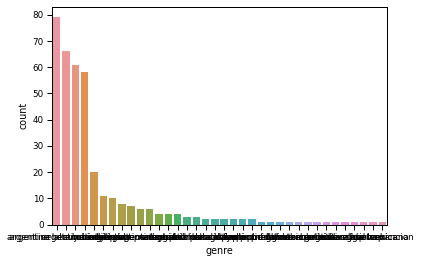

In [9]:
simple_df = songs_base.copy()
first_df = simple_df.copy()
first_df["genres"] = first_df["genres"].apply(lambda x: x[0])
first_dist = first_df["genres"].value_counts()
first_dist_df = pd.DataFrame({'genre':first_dist.index, 'count':first_dist.values})
#columns=["genre", "counts"])
#simple_dist_df
#sns.barplot(x=first_dist_df["genre"],y=first_dist_df["count"])
a_new_try = first_df[first_df["genres"] != "argentine rock" ]
a_new_try = a_new_try[a_new_try["genres"] != "latin"]
a_new_try = a_new_try[a_new_try["genres"] != "cuarteto"]
new_dist = a_new_try["genres"].value_counts()
new_dist_df = pd.DataFrame({'genre':new_dist.index, 'count':new_dist.values})

sns.barplot(x=new_dist_df["genre"],y=new_dist_df["count"])


using a random choice we get a slightly more balanced dataset

In [12]:
a_new_try.count()

song_name           376
song_id             376
artists             376
artists_id          376
album_name          376
album_id            376
audio_features      376
genres              376
lyrics_sentiment    376
dtype: int64

In [29]:
#a_new_try
import ast

df = a_new_try.copy()
audio_thing= df["audio_features"].apply(lambda x: ast.literal_eval(x))
audio_features_base = pd.DataFrame(list(audio_thing))
audio_features = audio_features_base.columns
#df.drop(["audio_features"],axis=1, inplace=True)
#df = pd.concat([df,audio_features_base],axis=1)
#df2 = df.join(audio_features_base)
audio_features_base
#print(df.count(), " vs ", audio_features_base.count())
df = df.reset_index(drop=True)
audio_features_base = audio_features_base.reset_index(drop=True)
df2 = pd.concat([df,audio_features_base],axis=1)
df2.count()

song_name           376
song_id             376
artists             376
artists_id          376
album_name          376
album_id            376
audio_features      376
genres              376
lyrics_sentiment    376
danceability        376
energy              376
key                 376
loudness            376
mode                376
speechiness         376
acousticness        376
instrumentalness    376
liveness            376
valence             376
tempo               376
type                376
id                  376
uri                 376
track_href          376
analysis_url        376
duration_ms         376
time_signature      376
dtype: int64

dataset split

In [30]:
other = df2[audio_features].join( df['lyrics_sentiment'])
sanitized = df2.drop(["uri", "analysis_url", "track_href", "id", "type"],1)

In [28]:
sanitized.count()

song_name           376
song_id             376
artists             376
artists_id          376
album_name          376
album_id            376
audio_features      376
genres              376
lyrics_sentiment    376
danceability        376
energy              376
key                 376
loudness            376
mode                376
speechiness         376
acousticness        376
instrumentalness    376
liveness            376
valence             376
tempo               376
duration_ms         376
time_signature      376
dtype: int64

In [42]:
from sklearn import model_selection, tree
features = ["danceability", "energy","key","loudness","mode",
            "speechiness","acousticness","instrumentalness","liveness",
           "valence","tempo","lyrics_sentiment"]

X = sanitized[features]
Y = df2["genres"]


In [41]:
sanitized


,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key'...",art pop,0.0013,0.161,...,-11.210,0,0.0472,0.4860,0.40900,0.3710,0.0926,161.092,233079,5
1,Anoche,1cwTMSQeMaA9fVKEF1iWeD,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.23, 'energy': 0.434, 'key':...",art pop,0.9970,0.230,...,-12.402,0,0.0551,0.5700,0.00000,0.1150,0.0834,80.793,216905,5
2,Sin Rumbo,0aL27vskbMpwsMGUkHm3Zf,['Arca'],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.289, 'energy': 0.28, 'key':...",art pop,0.0000,0.289,...,-15.335,1,0.0433,0.8740,0.00443,0.1240,0.0391,124.835,215773,3
3,La Gata Bajo la Lluvia,2kfSFdq2h0xLXq01em1zc7,['Rocío Dúrcal'],['2uyweLa0mvPZH6eRzDddeB'],Sus 16 Grandes Exitos,1QXxmsxolhkqiFtI1mpX4i,"{'danceability': 0.499, 'energy': 0.648, 'key'...",bolero,0.0057,0.499,...,-5.812,1,0.0331,0.7230,0.00000,0.5760,0.4640,88.140,219107,4
4,Querida,5ySxlyvySBhIEvoO2xx7uT,['Juan Gabriel'],['2MRBDr0crHWE5JwPceFncq'],Recuerdos II,1xrQ48Vvnvm3SmAbnIukGt,"{'danceability': 0.528, 'energy': 0.383, 'key'...",cancion melodica,0.0000,0.528,...,-11.170,1,0.0258,0.3760,0.00000,0.1100,0.4600,89.089,328320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,Hermanos,7uMYwMzCDDB2QJWaKGaubO,['Bandalos Chinos'],['0wn2qDKzeFlhjRUtJAwJjp'],BACH,4SsEredFwBsSDyu6tF8cCg,"{'danceability': 0.675, 'energy': 0.525, 'key'...",argentine alternative rock,0.0013,0.675,...,-9.471,1,0.0263,0.7440,0.10800,0.1670,0.1910,112.008,227280,3
372,Lento,7rkUinRHZtLtTyLz5pWmG8,['Bandalos Chinos'],['0wn2qDKzeFlhjRUtJAwJjp'],BACH,4SsEredFwBsSDyu6tF8cCg,"{'danceability': 0.669, 'energy': 0.655, 'key'...",argentine alternative rock,0.0000,0.669,...,-6.323,0,0.0221,0.1020,0.18000,0.1030,0.7680,89.991,288507,4
373,El Concierto,69C9EA7elW3hWyheFseUA5,['Bandalos Chinos'],['0wn2qDKzeFlhjRUtJAwJjp'],BACH,4SsEredFwBsSDyu6tF8cCg,"{'danceability': 0.684, 'energy': 0.297, 'key'...",argentine alternative rock,0.0000,0.684,...,-10.826,0,0.0317,0.7400,0.00144,0.5070,0.2400,122.004,239133,4
374,Ácido,6rUSxtUiecOgWAp6wUrlR5,['Bandalos Chinos'],['0wn2qDKzeFlhjRUtJAwJjp'],BACH,4SsEredFwBsSDyu6tF8cCg,"{'danceability': 0.671, 'energy': 0.717, 'key'...",argentine alternative rock,1.0000,0.671,...,-7.832,0,0.0317,0.0139,0.64300,0.1180,0.6250,114.951,242307,4


In [43]:
from sklearn.preprocessing import LabelEncoder
# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

In [35]:
len(label_encoded_y)

376

In [44]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, label_encoded_y, test_size=0.3, random_state=42)


## XGBoost

In [45]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [46]:
y_pred = xg_reg.predict(X_test)
predictions = [round(value) for value in y_pred]

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 11.50%


In [54]:
y_predictions = xg_gridsearched.predict(X_train)
predictions = [round(value) for value in y_predictions_grid]

print ('Accuracy: %d ' % ((np.sum(y_train == predictions))/float(y_train.size)*100))
#predictions_grid

Accuracy: 15 


In [47]:
# With gridsearch
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}


In [48]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
model = xgb.XGBRegressor()
random_search=RandomizedSearchCV(model,
                                 param_distributions=params,
                                 n_iter=5,
                                 n_jobs=-1,
                                 cv=5,
                                 verbose=3)
random_search.fit(X,label_encoded_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    2.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          validate_parameters=None,
                                          verbosity=None),
                   iid='deprecated', n_iter=5, n_jobs=-1,
     

In [49]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [50]:
random_search.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1}

In [51]:
xg_gridsearched = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
xg_gridsearched.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [52]:
y_predictions_grid = xg_gridsearched.predict(X_train)
predictions_grid = [round(value) for value in y_predictions_grid]

print ('Accuracy: %d ' % ((np.sum(y_train == predictions_grid))/float(y_train.size)*100))
#predictions_grid

Accuracy: 15 


In [53]:
y_pred_grid = xg_gridsearched.predict(X_test)
predictions_grid = [round(value) for value in y_pred_grid]

from sklearn.metrics import accuracy_score
accuracy_grid = accuracy_score(y_test, predictions_grid)
print("Accuracy: %.2f%%" % (accuracy_grid * 100.0))


Accuracy: 9.73%


In [57]:
X.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,lyrics_sentiment
0,0.161,0.482,1,-11.210,0,0.0472,0.486,0.409,0.371,0.0926,161.092,233079,5,0.0013
1,0.230,0.434,10,-12.402,0,0.0551,0.570,0.000,0.115,0.0834,80.793,216905,5,0.9970


In [65]:
from sklearn import model_selection, tree
features = ["key","valence","tempo","lyrics_sentiment"]
X = sanitized[features]
Y = df["genres"]
from sklearn.preprocessing import LabelEncoder
# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, label_encoded_y, test_size=0.3, random_state=42)



In [66]:
xg_gridsearched = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=8,
             min_child_weight=3, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
xg_gridsearched.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=8,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [69]:
y_predictions_grid = xg_gridsearched.predict(X_train)
predictions_grid = [round(value) for value in y_predictions_grid]

print ('Accuracy: %d ' % ((np.sum(y_train == predictions_grid))/float(y_train.size)*100))
#predictions_grid

Accuracy: 0 


In [ ]:
#without encoding Y
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)


## Decision Trees

In [241]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X_train, y_train)

In [242]:
predictions = clf.predict(X_train)
print ('Accuracy: %d ' % ((np.sum(y_train == predictions))/float(y_train.size)*100))

Accuracy: 13 


In [243]:
predictions = clf.predict(X_valid)
print ('Accuracy: %d ' % ((np.sum(y_valid == predictions))/float(y_valid.size)*100))

Accuracy: 13 


In [244]:
score = clf.score(X_valid, y_valid)
score

0.13445378151260504

In [245]:
predicts = clf.predict(X_valid.head(1))
predicts
#track_by_feature("danceability", 0.631)

array(['cuarteto'], dtype=object)

In [200]:
#more aux functions
def track_by_feature(feature, value):
    track_id = audio_features_base[audio_features_base[feature]==value]['id']
    track_id = track_id.values.item(0)
    return df[df['song_id']== track_id]
#example use: 
#print(track_by_feature("valence",0.039100))
#track_by_feature("speechiness",0.492000)


In [201]:
track_by_feature("danceability", 0.631)

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,danceability,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
96,Lluvia,09O9vdg73P50pPHC2FiWzV,['La Mona Jimenez'],['64DFKvGarD5nmkfaIiiakf'],Discografía Completa - Volumen 3,1Cs9XYXDQvBlEqDN3jDoHP,"{'danceability': 0.631, 'energy': 0.94, 'key':...",cuarteto,0.0001,0.631,...,0.0673,0.817,150.073,audio_features,09O9vdg73P50pPHC2FiWzV,spotify:track:09O9vdg73P50pPHC2FiWzV,https://api.spotify.com/v1/tracks/09O9vdg73P50...,https://api.spotify.com/v1/audio-analysis/09O9...,286493,4


Random Forest

In [246]:
from sklearn import ensemble

In [247]:
clf_random_forest = ensemble.RandomForestClassifier(random_state=2)
clf.fit(X_train, y_train);

In [248]:
predictions_train_forest = clf_random_forest.predict(X_train)
print ('Accuracy: %d ' % ((np.sum(y_train == predictions))/float(y_train.size)*100))

Accuracy: 99 


In [250]:
predictions_forest = clf_random_forest.predict(X_valid)
print ('Accuracy: %d ' % ((np.sum(y_valid == predictions))/float(y_valid.size)*100))

Accuracy: 21 


SVM

In [309]:

import sklearn.linear_model
import sklearn.neural_network

clf_svm = sklearn.svm.LinearSVC(random_state=2,dual=False, C=0.4)
#clf_svm = LogisticRegression(solver='lbfgs', max_iter=10000)
clf_svm.fit(X_train, y_train)


LinearSVC(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=2, tol=0.0001,
          verbose=0)

In [310]:
predictions_train_svm = clf_svm.predict(X_train)
print ('Accuracy: %d ' % ((np.sum(y_train == predictions_train_svm))/float(y_train.size)*100))

Accuracy: 11 


In [311]:
predictions_svm = clf_svm.predict(X_valid)
print ('Accuracy: %d ' % ((np.sum(y_valid == predictions_svm))/float(y_valid.size)*100))

Accuracy: 10 


In [312]:
clf_svm.score(X_valid,y_valid)

0.10504201680672269

K NEIGHBORS

In [313]:
from sklearn.neighbors import KNeighborsClassifier

clf_neigh = KNeighborsClassifier(n_neighbors=3)
clf_neigh.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [314]:
predictions_train_neigh = clf_neigh.predict(X_train)
print ('Accuracy: %d ' % ((np.sum(y_train == predictions_train_neigh))/float(y_train.size)*100))

Accuracy: 36 


In [324]:
predictions_neigh = clf_neigh.predict(X_valid)
print ('Accuracy: %d ' % ((np.sum(y_valid == predictions_train_neigh))/float(y_valid.size)*100))

Accuracy: 3 


In [328]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
cm = confusion_matrix(y_valid, predictions_neigh) 
cm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

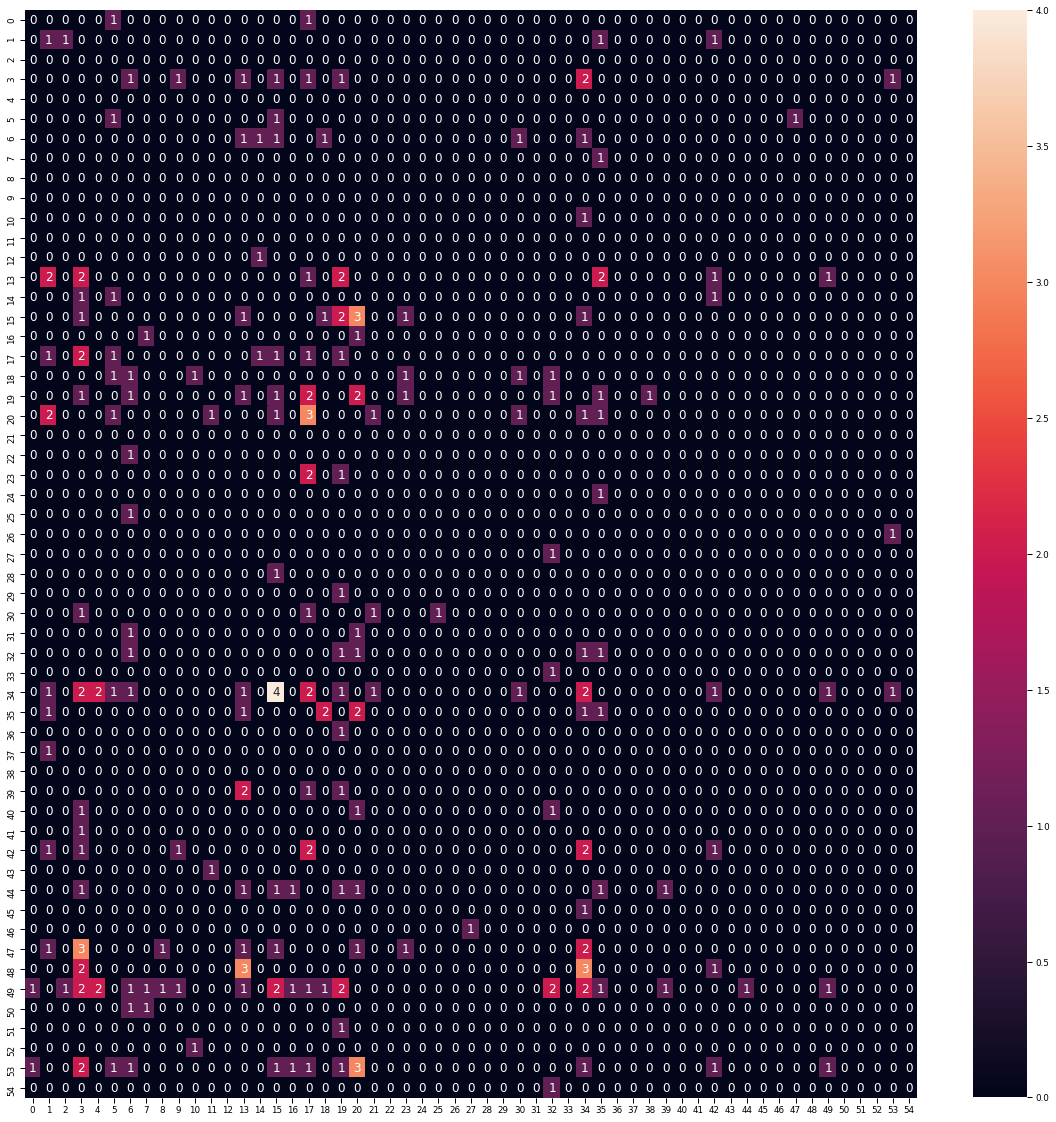

In [336]:
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, annot_kws={"size": 12})

In [ ]:
Multiclass

In [320]:
df_mc = pd.concat([songs_base,audio_features_base],axis=1)
other_mc = pd.concat([df_mc[audio_features], df_mc['lyrics_sentiment']], axis=1)
sanitized_multiclass = other_mc.drop(["uri", "analysis_url", "track_href", "id", "type"],1)
X_mc = sanitized_multiclass
y_mc = songs_base["genres"]
X_train_mc, X_test_mc, y_train_mc, y_test_mc = model_selection.train_test_split(X_mc, y_mc, test_size=0.3, random_state=42)


In [321]:
clf_neigh_mc = KNeighborsClassifier(n_neighbors=3)
clf_neigh_mc.fit(X_train_mc,y_train_mc)

ValueError: Unknown label type: 'unknown'

### 2) Elegir tres modelos de clasificadores multiclase

Aquí escogeremos tres modelos diferentes y luego compararemos su rendimiento para esta tarea. El procedimiento será el siguiente:
- Inicializar los modelos
- Entrenarlos usando el split **train** de los datos

**Recomendación:**
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)

### 3) Informe: Comparar el rendimiento de los modelos

Una vez entrenados los tres modelos, compararemos su rendimiento:
- Correr los modelos usando el split **test**
- Obtener el reporte de clasificación y la matriz de confusión para cada modelo
- Graficar llevando a 2 dimensiones nuestro split **test** pintando con colores diferentes según la etiqueta correspondiente.
- Graficar de manera similar los resultados obtenidos con cada clasificador y sobre esto la función de clasificación obtenida.
- Guardar los modelos usando **pickle**
- Discutir los resultados obtenidos

**Recomendación:**
- Prestar atención a la [documentación de sklearn](https://scikit-learn.org/stable/)

### 4) Tareas adicionales:

Estas tareas servirán para extrapolar un poco el trabajo básico, y también sumarán puntos extra. Deben elegir una o más de las siguientes:
-  Análisis sobre el balance de clases del dataset, balanceo usando **subsampling** u **oversampling** y comparación de resultados vs el modelo básico
- Optimización de hiperparámetros y comparación de resultados vs el modelo básico
- Graficar importancia de features
- Graficar correlación de features

**Recomendación:**
- Hacer varias ahora puede ahorrarles tiempo en el futuro

In [37]:
#problemas de spotify's genres
get_genres(["0iutktJLkNNtErs8c3EoF6"])

['cumbia andina mexicana', 'folclore jujeno', 'folklore argentino']